In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sc
import networkx as ntx
from numpy.random import choice
import scipy.sparse.linalg as spla
import pandas as pd

In [37]:
def E0(layers):
    m1=[]
    for j in np.arange(0,8*layers,8):
        m1.append([(i+j,i+1+j) for i in range(7)])
    return np.array(m1).reshape(-1,2)
def E1(layers):
    m2=[]
    for j in np.arange(0,8*(layers-1),8):
        m2.append(np.array([((j+i,j+7+i),(j+i,j+7+2+i)) for i in np.arange(1,7,2)]))
    m2=np.array(m2).reshape(-1,2)
    return m2
def E2(layers):
    m3=[]
    m3.append([(j+7,j+14) for j in np.arange(0,8*(layers-1),8)])
    m3=np.array(m3).reshape(-1,2)
    return m3

In [3]:
def create_graph(layers,seed):
    np.random.seed(seed)
    G = ntx.Graph()
    e0 = E0(layers)
    e1 = E1(layers)
    e2 = E2(layers)
    G.add_edges_from(e0)
    G.add_edges_from(e1)
    G.add_edges_from(e2)
    return G

In [ ]:
def create_graph2(layers,seed):
    np.random.seed(seed)
    G= ntx.grid_2d_graph(4,4)
    G = ntx.convert_node_labels_to_integers(G)
    return G


In [4]:
def create_3d_graph(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {}

    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    # Connect layers vertically (with the correction)
    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect bottom layer even nodes to external_node_1
    for node in G_2d.nodes:
        if node % 2 == 0:
            G_3d.add_edge(node_mapping[(node, 0)], external_node_1)  # Bottom layer (z=0)

    # Connect top layer odd nodes to external_node_2
    for node in G_2d.nodes:
        if node % 2 == 1 and node < max(G_2d.nodes):
            G_3d.add_edge(node_mapping[(node, depth - 1)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2


In [ ]:
create_3d_graph(4, 1, 10)

In [ ]:
print(list(create_3d_graph(4,1,2).neighbors(65)))

In [ ]:
# Extract node positions for plotting
#pos_3d = {node: (node[0], node[1]) for node in create_3d_graph(4, 1, 2).edges}  
#pos_3d

In [5]:
def generate_random_values(mean, std, seed, num_edges):
    np.random.seed(seed)
    return np.abs(np.random.normal(mean, std, num_edges))

In [45]:
def matrix_interactions(seed, depth, std):

    grid,a,b = create_3d_graph(4, seed, depth)  
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
    np.random.seed(seed)
    h= int(0.1 * num_edges)

    cap_values = np.abs(1 * np.concatenate((generate_random_values(100, std, seed, num_edges-h),generate_random_values(0.001, 0, seed, h))))
    np.random.shuffle(cap_values)
    interactions = 1 / cap_values
    #print(cap_values)

    # Initialize adjacency matrix with correct dimensions
    adjM = sc.lil_matrix((nodes, nodes))

    # Extract edges and ensure valid indices
    xxx = list(grid.edges())
    #print(xxx)


    # Fill adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(xxx):
        if i < a:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
        else :
            interaction_value = interactions[edge_idx]
            adjM[i, j] = 0.001
            adjM[j, i] = 0.001
            

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())

    return MI, a,b


In [21]:
n,m,o,h= matrix_interactions(1, 10, 1)

In [22]:
h

95

In [27]:
def R(seed,depth,std):
    MI,a,b = matrix_interactions(seed,depth,std)
    return MI[a, b] + MI[b, b] - MI[a,b] - MI[b, a] 

In [28]:
df = pd.DataFrame()

In [46]:
for depth in np.arange(10,100,10):
    print(depth)
    joop=[np.mean([R(seed,depth,std) for seed in range(50)]) for std in np.arange(0,500,50)]
    df[f"{depth}_roop"] = joop

10
20
30
40
50
60
70
80
90


In [38]:
# depth decides # no of flakes in the box
def create_3d_graph_ip(layers, seed, depth):
    G_2d = create_graph(layers, seed)
    G_3d = ntx.Graph()

    node_count = 0
    node_mapping = {} 
    
    for z in range(depth):
        for node in G_2d.nodes:
            G_3d.add_node(node_count)
            node_mapping[(node, z)] = node_count
            node_count += 1

    for edge in G_2d.edges:
        for z in range(depth):
            G_3d.add_edge(
                node_mapping[(edge[0], z)], node_mapping[(edge[1], z)]
            )

    for z in range(depth - 1):
        for node in G_2d.nodes:
            if node % 2 == 1 and node < max(G_2d.nodes):
                for neighbor in G_2d.neighbors(node):
                    if neighbor % 2 == 0:  # Even neighbors in the current layer
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )
                    elif neighbor % 2 == 1 and neighbor > node: # Odd neighbors in the current layer with a higher index
                        G_3d.add_edge(
                            node_mapping[(node, z)], node_mapping[(neighbor, z + 1)]
                        )

    node_count = max(G_3d.nodes) + 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 1
    external_node_1 = node_count

    node_count += 1
    G_3d.add_node(node_count)  # node_in_3d_graph + 2
    external_node_2 = node_count

    # Connect side layer even nodes to external_node_1
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 0:
                G_3d.add_edge(node_mapping[(node, x)], external_node_1)  # side l

    # Connect side layer odd nodes to external_node_2
    for x in range(depth):
        for node in G_2d.nodes:
            if node % 8 == 7 :
                G_3d.add_edge(node_mapping[(node, x)], external_node_2)  # Top layer (z=depth-1)


    return G_3d,external_node_1,external_node_2


In [47]:
def matrix_interactions_ip(seed, depth, std):

    grid,a,b = create_3d_graph_ip(4, seed, depth)  # Assuming this function exists
    num_edges = grid.number_of_edges()
    nodes = grid.number_of_nodes()
    
    np.random.seed(seed)
    
    h= int(0.1*num_edges)

    
    cap_values = np.abs(1 * np.concatenate((generate_random_values(100, std, seed, num_edges-h),generate_random_values(0.001, 0, seed, h))))
    np.random.shuffle(cap_values)
    interactions = 1 / cap_values

    # Initialize adjacency matrix with correct dimensions
    adjM = sc.lil_matrix((nodes, nodes))

    # Extract edges and ensure valid indices
    xxx = list(grid.edges())
    #print(xxx)

    # Fill adjacency matrix with interaction values
    for edge_idx, (i, j) in enumerate(xxx):
        if i < a:
            interaction_value = interactions[edge_idx]
            adjM[i, j] = interaction_value
            adjM[j, i] = interaction_value
        else :
            interaction_value = interactions[edge_idx]
            adjM[i, j] = 0.001
            adjM[j, i] = 0.001
            

    # Set diagonal elements based on row sums
    adjM.setdiag(-1 * adjM.sum(axis=1).A1 - 0.0001)

    # Invert the matrix (assuming adjM is negative definite)
    MI = spla.inv(-1 * adjM.tocsc())

    return MI, a,b


In [48]:
def R_ip(seed,depth,h):
    MI,a,b = matrix_interactions_ip(seed,depth,h)
    return MI[a, b] + MI[b, b] - MI[a,b] - MI[b, a] 

In [49]:
for depth in np.arange(10,100,10):
    print(depth)
    joop=[np.mean([R_ip(seed,depth,std) for seed in range(50)]) for std in np.arange(0,500,50)]
    df[f"{depth}_rip"] = joop

10
20
30
40
50
60
70
80
90


In [58]:
df.head()

,{depth}_roop,10_roop,20_roop,30_roop,40_roop,50_roop,60_roop,70_roop,80_roop,90_roop,10_rip,20_rip,30_rip,40_rip,50_rip,60_rip,70_rip,80_rip,90_rip
0,33.406147,16.886871,25.605025,29.939378,31.655500,32.493104,32.701204,32.805695,32.716994,33.001388,3.413006,1.589192,1.079676,0.789641,0.638878,0.518183,0.446756,0.385766,0.342669
1,28.778914,13.044184,20.327212,24.974980,26.844904,27.497784,28.095227,28.126904,28.258111,28.535228,2.570345,1.179976,0.791281,0.586976,0.468871,0.381824,0.326220,0.284535,0.253886
2,26.380654,11.459390,17.661926,22.267624,24.307315,25.242041,25.855857,25.867530,26.235273,26.174931,2.169598,0.992297,0.676306,0.492918,0.397632,0.322952,0.269030,0.234041,0.210156
3,29.063641,13.398690,21.068330,25.260277,27.190686,28.059528,28.728536,28.225097,28.572089,28.865895,2.465698,1.161168,0.787580,0.587671,0.464530,0.382238,0.324644,0.275568,0.249736
4,32.091656,16.217002,24.683656,28.768982,30.925166,31.926872,31.956363,31.887430,31.606931,31.914620,3.068027,1.408683,0.944655,0.707841,0.561503,0.463094,0.393431,0.332895,0.304215


Text(0.5, 1.0, '$R_{\\mu} = 100$, # of hostpots = 10%')

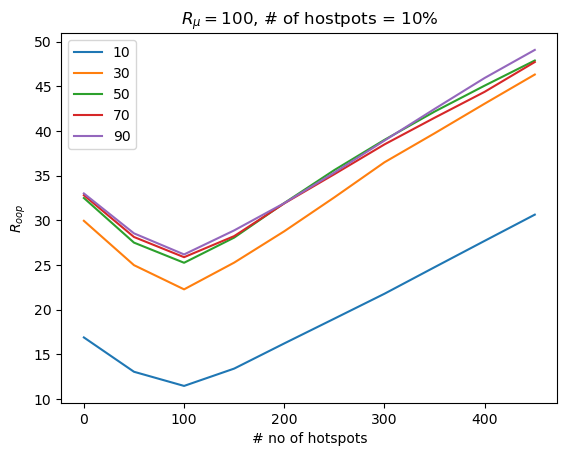

In [67]:
for x in np.arange(10,100,20):
    plt.plot(np.arange(0,500,50),df[f'{x}_roop'],label=f'{x}')
plt.xlabel('# no of hotspots')
plt.ylabel(r'$R_{oop}$')
plt.legend()
plt.title(r'$R_{\mu} = 100$, # of hostpots = 10%')

Text(0.5, 1.0, '$R_{\\mu} = 100$, # of hotspots = 10%')

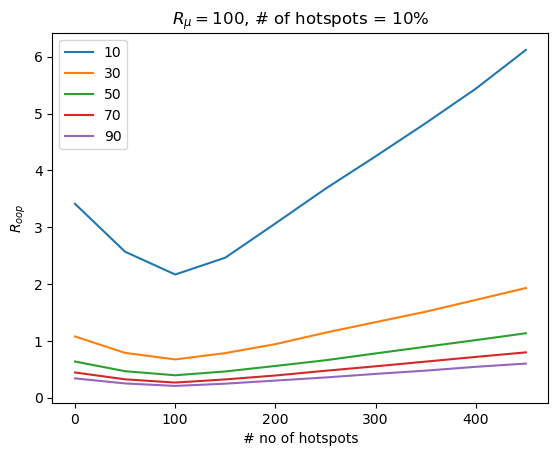

In [70]:
for x in np.arange(10,100,20):
    plt.plot(np.arange(0,500,50),df[f'{x}_rip'],label=f'{x}')
plt.xlabel('# no of hotspots')
plt.ylabel(r'$R_{oop}$')
plt.legend()
plt.title(r'$R_{\mu} = 100$, # of hotspots = 10%')

Text(0.5, 1.0, '$R_{\\mu} = 100$, # of hotspots = 10%')

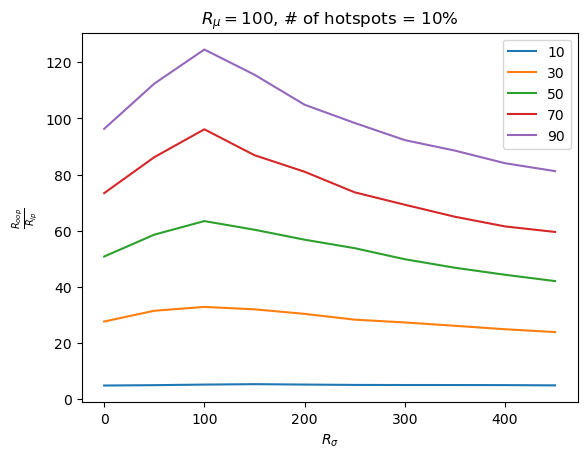

In [77]:
for x in np.arange(10,100,20):
    plt.plot(np.arange(0,500,50),df[f'{x}_roop']/df[f'{x}_rip'],label=f'{x}')
plt.xlabel(r'$R_{\sigma}$')
plt.ylabel(r'$\frac{R_{oop}}{R_{ip}}$')
plt.legend()
plt.title(r'$R_{\mu} = 100$, # of hotspots = 10%')

In [ ]:
df = pd.DataFrame()
df["Rop"] = joop
df["Rip"]= jip

In [ ]:
df["ratio"] = 1*(df["Rop"]/df["Rip"])

In [56]:
df.to_csv('resistance_brick.csv')

In [ ]:
plt.plot(np.arange(10,100,1),df["Rop"],label=r'$R_{op}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{op}$',fontsize=15)
plt.title(r'$R_{\mu} = 100$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)


In [ ]:
plt.plot(np.arange(10,100,1),df["Rip"],label=r'$R_{ip}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$R_{ip}$',fontsize=15)
plt.title(r'$R_{\mu} = 100$, # of flakes = 1600,# of in plane = 16',fontsize=15)
plt.grid(True)

In [ ]:
plt.plot(np.arange(10, 100,1), df["ratio"], label=r'$\frac{\sigma_{op}}{\sigma_{ip}}$')
plt.xlabel('Std',fontsize=15)
plt.ylabel(r'$\frac{R_{op}}{R_{ip}}$',fontsize=15)
plt.grid(True)

In [ ]:
generate_random_values(100, 1, 1, 10)

In [ ]:
np.abs(1 * np.concatenate((generate_random_values(100, 10, 0, 10-5),generate_random_values(0.001, 0, 0,5))))